## 导入依赖库

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import gc
import os
import json
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass
from abc import ABC, abstractmethod
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.base import clone
from scipy.stats import pearsonr
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from koolbox import Trainer
import optuna

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## 运行配置

In [2]:
@dataclass
class Config:
    """Configuration class for the prediction pipeline."""
    
    # Updated data paths to match directory structure
    train_path: str = "../kaggle/input/drw-crypto-market-prediction/train.parquet"
    test_path: str = "../kaggle/input/drw-crypto-market-prediction/test.parquet"
    sample_sub_path: str = "../kaggle/input/drw-crypto-market-prediction/sample_submission.csv"
    
    # Output paths
    models_dir: str = "../models/"
    results_dir: str = "../result/"
    
    # Model parameters
    target: str = "label"
    n_folds: int = 5
    seed: int = 42
    
    # Optimization parameters
    run_optuna: bool = True
    n_optuna_trials: int = 100  # Reduced for notebook execution
    
    # GPU settings
    use_gpu: bool = True  # Set to False if GPU is not available
    gpu_id: int = 0
    
    # Columns to drop
    cols_to_drop: List[str] = None
    
    def __post_init__(self):
        # Create directories if they don't exist
        os.makedirs(self.models_dir, exist_ok=True)
        os.makedirs(self.results_dir, exist_ok=True)
        
        if self.cols_to_drop is None:
            self.cols_to_drop = [
                'X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 
                'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716',
                'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872', 'X104', 'X110', 'X116',
                'X122', 'X128', 'X134', 'X140', 'X146', 'X152', 'X158', 'X164', 'X170', 'X176',
                'X182', 'X351', 'X357', 'X363', 'X369', 'X375', 'X381', 'X387', 'X393', 'X399',
                'X405', 'X411', 'X417', 'X423', 'X429'
            ]

## 数据预处理

In [3]:
class DataProcessor:
    """Handles data loading, preprocessing, and feature engineering."""
    
    def __init__(self, config: Config):
        self.config = config
        
    def reduce_memory_usage(self, df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
        """
        Optimize dataframe memory usage by downcasting numeric types.
        
        Args:
            df: Input dataframe
            dataset_name: Name for logging purposes
            
        Returns:
            Memory-optimized dataframe
        """
        print(f'Reducing memory usage for: {dataset_name}')
        initial_mem = df.memory_usage().sum() / 1024**2
        
        for col in df.columns:
            col_type = df[col].dtype
            c_min, c_max = df[col].min(), df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        
        final_mem = df.memory_usage().sum() / 1024**2
        reduction = 100 * (initial_mem - final_mem) / initial_mem
        
        print(f'--- Memory usage before: {initial_mem:.2f} MB')
        print(f'--- Memory usage after: {final_mem:.2f} MB')
        print(f'--- Decreased memory usage by {reduction:.1f}%\n')
        
        return df
    
    def create_interaction_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create interaction features between different quantity types."""
        df = df.copy()
        
        # Basic interactions
        df['bid_ask_interaction'] = df['bid_qty'] * df['ask_qty']
        df['bid_buy_interaction'] = df['bid_qty'] * df['buy_qty']
        df['bid_sell_interaction'] = df['bid_qty'] * df['sell_qty']
        df['ask_buy_interaction'] = df['ask_qty'] * df['buy_qty']
        df['ask_sell_interaction'] = df['ask_qty'] * df['sell_qty']
        df['buy_sell_interaction'] = df['buy_qty'] * df['sell_qty']
        
        return df
    
    def create_market_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create advanced market microstructure features."""
        df = df.copy()
        eps = 1e-8  # Small constant to avoid division by zero
        
        # Spread and ratio features
        df['spread_indicator'] = (df['ask_qty'] - df['bid_qty']) / (df['ask_qty'] + df['bid_qty'] + eps)
        df['buy_sell_ratio'] = df['buy_qty'] / (df['sell_qty'] + eps)
        df['bid_ask_ratio'] = df['bid_qty'] / (df['ask_qty'] + eps)
        
        # Volume-weighted features
        for qty_type in ['buy', 'sell', 'bid', 'ask']:
            df[f'volume_weighted_{qty_type}'] = df[f'{qty_type}_qty'] * df['volume']
        
        # Order flow and pressure indicators
        df['order_flow_imbalance'] = (df['buy_qty'] - df['sell_qty']) / (df['volume'] + eps)
        df['buying_pressure'] = df['buy_qty'] / (df['volume'] + eps)
        df['selling_pressure'] = df['sell_qty'] / (df['volume'] + eps)
        
        # Liquidity measures
        df['total_liquidity'] = df['bid_qty'] + df['ask_qty']
        df['liquidity_imbalance'] = (df['bid_qty'] - df['ask_qty']) / (df['total_liquidity'] + eps)
        df['relative_spread'] = (df['ask_qty'] - df['bid_qty']) / (df['volume'] + eps)
        
        # Trade intensity and execution quality
        df['trade_intensity'] = (df['buy_qty'] + df['sell_qty']) / (df['volume'] + eps)
        df['avg_trade_size'] = df['volume'] / (df['buy_qty'] + df['sell_qty'] + eps)
        df['net_trade_flow'] = (df['buy_qty'] - df['sell_qty']) / (df['buy_qty'] + df['sell_qty'] + eps)
        
        # Market depth and activity
        df['depth_ratio'] = df['total_liquidity'] / (df['volume'] + eps)
        df['volume_participation'] = (df['buy_qty'] + df['sell_qty']) / (df['total_liquidity'] + eps)
        df['market_activity'] = df['volume'] * df['total_liquidity']
        
        # Advanced indicators
        df['effective_spread_proxy'] = np.abs(df['buy_qty'] - df['sell_qty']) / (df['volume'] + eps)
        df['realized_volatility_proxy'] = np.abs(df['order_flow_imbalance']) * df['volume']
        df['normalized_buy_volume'] = df['buy_qty'] / (df['bid_qty'] + eps)
        df['normalized_sell_volume'] = df['sell_qty'] / (df['ask_qty'] + eps)
        
        # Complex interactions
        df['liquidity_adjusted_imbalance'] = df['order_flow_imbalance'] * df['depth_ratio']
        df['pressure_spread_interaction'] = df['buying_pressure'] * df['spread_indicator']
        
        return df
    
    def clean_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Clean data by handling infinite values and NaNs."""
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.fillna(0)
        return df
    
    def load_and_process_data(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Load and process training and test data.
        
        Returns:
            Tuple of (X_train, y_train, X_test)
        """
        print("Loading data...")
        train = pd.read_parquet(self.config.train_path).reset_index(drop=True)
        test = pd.read_parquet(self.config.test_path).reset_index(drop=True)
        
        # Drop unnecessary columns
        train = train.drop(columns=self.config.cols_to_drop)
        test = test.drop(columns=["label"] + self.config.cols_to_drop)
        
        # Reduce memory usage
        train = self.reduce_memory_usage(train, "train")
        test = self.reduce_memory_usage(test, "test")
        
        print("Creating features...")
        # Feature engineering
        train = self.create_interaction_features(train)
        train = self.create_market_features(train)
        train = self.clean_data(train)
        
        test = self.create_interaction_features(test)
        test = self.create_market_features(test)
        test = self.clean_data(test)
        
        # Split features and target
        X_train = train.drop(self.config.target, axis=1)
        y_train = train[self.config.target]
        X_test = test
        
        print(f"Training data shape: {X_train.shape}")
        print(f"Test data shape: {X_test.shape}")
        print(f"Number of features: {X_train.shape[1]}")
        
        return X_train, y_train, X_test


# 基础模型

In [4]:
class BaseModel(ABC):
    """Abstract base class for all models."""
    
    def __init__(self, config: Config):
        self.config = config
        self.trainer = None
        self.fold_scores = None
        self.oof_preds = None
        
    @abstractmethod
    def get_model_params(self) -> Dict[str, Any]:
        """Return model parameters."""
        pass
    
    @abstractmethod
    def get_model_name(self) -> str:
        """Return model name."""
        pass
    
    def _pearsonr(self, y_true, y_pred):
        """Pearson correlation coefficient."""
        return pearsonr(y_true, y_pred)[0]
    
    def train(self, X: pd.DataFrame, y: pd.Series) -> Tuple[List[float], np.ndarray]:
        """
        Train the model using cross-validation.
        
        Args:
            X: Training features
            y: Training target
            
        Returns:
            Tuple of (fold_scores, oof_predictions)
        """
        print(f"Training {self.get_model_name()}...")
        
        model_params = self.get_model_params()
        model_class = self._get_model_class()
        
        self.trainer = Trainer(
            model_class(**model_params),
            cv=KFold(n_splits=self.config.n_folds, shuffle=False),
            metric=self._pearsonr,
            task="regression",
            metric_precision=6
        )
        
        self.trainer.fit(X, y)
        self.fold_scores = self.trainer.fold_scores
        self.oof_preds = self.trainer.oof_preds
        
        print(f"   Fold scores: {self.fold_scores}")
        print(f"   Mean CV score: {np.mean(self.fold_scores):.6f}")
        print(f"   Std CV score: {np.std(self.fold_scores):.6f}")
        
        return self.fold_scores, self.oof_preds
    
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """Make predictions on new data."""
        if self.trainer is None:
            raise ValueError("Model must be trained before making predictions")
        return self.trainer.predict(X)
    
    @abstractmethod
    def _get_model_class(self):
        """Return the model class."""
        pass


class LightGBMModel(BaseModel):
    """LightGBM model with GPU support."""
    
    def __init__(self, config: Config, boosting_type: str = "gbdt"):
        super().__init__(config)
        self.boosting_type = boosting_type
        
    def get_model_name(self) -> str:
        return f"LightGBM ({self.boosting_type})"
    
    def _get_model_class(self):
        return LGBMRegressor
    
    def get_model_params(self) -> Dict[str, Any]:
        """Return optimized LightGBM parameters with GPU support."""
        base_params = {
            "random_state": self.config.seed,
            "n_jobs": -1,
            "verbose": -1,
            "boosting_type": self.boosting_type,
        }
        
        # Add GPU support if enabled
        if self.config.use_gpu:
            base_params["device"] = "gpu"
            base_params["gpu_platform_id"] = 0
            base_params["gpu_device_id"] = self.config.gpu_id
        
        if self.boosting_type == "gbdt":
            specific_params = {
                "colsample_bytree": 0.5625888953382505,
                "learning_rate": 0.029312951475451557,
                "min_child_samples": 63,
                "min_child_weight": 0.11456572852335424,
                "n_estimators": 126,
                "num_leaves": 37,
                "reg_alpha": 85.2476527854083,
                "reg_lambda": 99.38305361388907,
                "subsample": 0.450669817684892,
            }
        else:  # goss
            specific_params = {
                "colsample_bytree": 0.34695458228489784,
                "learning_rate": 0.031023014900595287,
                "min_child_samples": 30,
                "min_child_weight": 0.4727729225033618,
                "n_estimators": 220,
                "num_leaves": 58,
                "reg_alpha": 38.665994901468224,
                "reg_lambda": 92.76991677464294,
                "subsample": 0.4810891284493255,
            }
        
        return {**base_params, **specific_params}


class XGBoostModel(BaseModel):
    """XGBoost model with GPU support."""
    
    def get_model_name(self) -> str:
        return "XGBoost"
    
    def _get_model_class(self):
        return XGBRegressor
    
    def get_model_params(self) -> Dict[str, Any]:
        """Return optimized XGBoost parameters with GPU support."""
        params = {
            "random_state": self.config.seed,
            "n_jobs": -1,
            "verbosity": 0,
            "colsample_bylevel": 0.4778015829774066,
            "colsample_bynode": 0.362764358742407,
            "colsample_bytree": 0.7107423488010493,
            "gamma": 1.7094857725240398,
            "learning_rate": 0.02213323588455387,
            "max_depth": 20,
            "max_leaves": 12,
            "min_child_weight": 16,
            "n_estimators": 1667,
            "reg_alpha": 39.352415706891264,
            "reg_lambda": 75.44843704068275,
            "subsample": 0.06566669853471274,
        }
        
        # Add GPU support if enabled
        if self.config.use_gpu:
            params["tree_method"] = "gpu_hist"
            params["gpu_id"] = self.config.gpu_id
        
        return params

## 整合模型

In [5]:
class EnsembleModel:
    """Ridge regression ensemble model."""
    
    def __init__(self, config: Config):
        self.config = config
        self.best_params = None
        self.trainer = None
        self.coefficients = None
        
    def _pearsonr(self, y_true, y_pred):
        """Pearson correlation coefficient."""
        return pearsonr(y_true, y_pred)[0]
    
    def _optimize_hyperparameters(self, X: pd.DataFrame, y: pd.Series) -> Dict[str, Any]:
        """Optimize Ridge hyperparameters using Optuna."""
        
        def objective(trial):
            params = {
                "random_state": self.config.seed,
                "alpha": trial.suggest_float("alpha", 0, 1000),
                "tol": trial.suggest_float("tol", 1e-6, 1e-2),
                "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
                "positive": trial.suggest_categorical("positive", [True, False])
            }
            
            trainer = Trainer(
                Ridge(**params),
                cv=KFold(n_splits=self.config.n_folds, shuffle=False),
                metric=self._pearsonr,
                task="regression",
                verbose=False
            )
            trainer.fit(X, y)
            
            return np.mean(trainer.fold_scores)
        
        print("Optimizing Ridge hyperparameters with Optuna...")
        sampler = optuna.samplers.TPESampler(seed=self.config.seed, multivariate=True)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(objective, n_trials=self.config.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
        
        best_params = study.best_params
        print(f"Best parameters found: {best_params}")
        print(f"Best CV score: {study.best_value:.6f}")
        
        # Cleanup
        del study
        gc.collect()
        
        return best_params
    
    def train(self, oof_predictions: Dict[str, np.ndarray], y: pd.Series) -> Tuple[List[float], np.ndarray]:
        """
        Train the ensemble model.
        
        Args:
            oof_predictions: Dictionary of out-of-fold predictions from base models
            y: Target values
            
        Returns:
            Tuple of (fold_scores, coefficients)
        """
        X_oof = pd.DataFrame(oof_predictions)
        
        # Optimize hyperparameters if enabled
        if self.config.run_optuna:
            self.best_params = self._optimize_hyperparameters(X_oof, y)
            ridge_params = {
                "random_state": self.config.seed,
                **self.best_params
            }
        else:
            ridge_params = {"random_state": self.config.seed}
        
        print("Training final Ridge ensemble...")
        self.trainer = Trainer(
            Ridge(**ridge_params),
            cv=KFold(n_splits=self.config.n_folds, shuffle=False),
            metric=self._pearsonr,
            task="regression",
            metric_precision=6
        )
        
        self.trainer.fit(X_oof, y)
        
        # Calculate average coefficients
        self.coefficients = np.zeros((1, X_oof.shape[1]))
        for estimator in self.trainer.estimators:
            self.coefficients += estimator.coef_
        self.coefficients = self.coefficients / len(self.trainer.estimators)
        
        fold_scores = self.trainer.fold_scores
        print(f"   Fold scores: {fold_scores}")
        print(f"   Mean CV score: {np.mean(fold_scores):.6f}")
        print(f"   Std CV score: {np.std(fold_scores):.6f}")
        
        return fold_scores, self.coefficients
    
    def predict(self, test_predictions: Dict[str, np.ndarray]) -> np.ndarray:
        """Make ensemble predictions."""
        X_test = pd.DataFrame(test_predictions)
        return self.trainer.predict(X_test)

## 可视化

In [6]:
class Visualizer:
    """Handles all visualization tasks."""
    
    @staticmethod
    def plot_ensemble_weights(coefficients: np.ndarray, model_names: List[str], title: str = "Ridge Ensemble Coefficients"):
        """Plot ensemble model coefficients."""
        sorted_indices = np.argsort(coefficients[0])[::-1]
        sorted_coeffs = coefficients[0][sorted_indices]
        sorted_names = np.array(model_names)[sorted_indices]
        
        plt.figure(figsize=(10, len(model_names) * 0.5))
        ax = sns.barplot(x=sorted_coeffs, y=sorted_names, palette="RdYlGn_r")
        
        for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_names)):
            ha = "left" if value >= 0 else "right"
            ax.text(value, i, f"{value:.3f}", va="center", ha=ha, color="black")
        
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))
        
        plt.title(title)
        plt.xlabel("")
        plt.ylabel("")
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_model_performance(scores: Dict[str, List[float]]):
        """Plot model performance comparison."""
        scores_df = pd.DataFrame(scores)
        mean_scores = scores_df.mean().sort_values(ascending=False)
        
        # Calculate plot limits
        min_score, max_score = mean_scores.min(), mean_scores.max()
        padding = (max_score - min_score) * 0.5
        lower_limit = min_score - padding
        upper_limit = max_score + padding
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, len(scores) * 0.5))
        
        # Box plot
        sns.boxplot(data=scores_df, order=mean_scores.index, ax=ax1, orient="h", color="grey")
        ax1.set_title("Fold Score Distribution")
        ax1.set_xlabel("")
        ax1.set_ylabel("")
        
        # Bar plot
        barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=ax2, color="grey")
        ax2.set_title("Average Score")
        ax2.set_xlabel("")
        ax2.set_xlim(left=lower_limit, right=upper_limit)
        ax2.set_ylabel("")
        
        # Highlight ensemble model
        for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
            color = "cyan" if "ensemble" in model.lower() else "grey"
            barplot.patches[i].set_facecolor(color)
            ax1.patches[i].set_facecolor(color)
            barplot.text(score, i, f"{score:.6f}", va="center")
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_target_distribution(y_train: pd.Series):
        """Visualize target distribution."""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(y_train, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Target Distribution')
        plt.xlabel('Label Value')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.boxplot(y_train, vert=True)
        plt.title('Target Box Plot')
        plt.ylabel('Label Value')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_model_correlations(oof_preds: pd.DataFrame):
        """Display correlation matrix of base model predictions."""
        plt.figure(figsize=(8, 6))
        correlation_matrix = oof_preds.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                    square=True, linewidths=0.5)
        plt.title('Correlation Matrix of Base Model Predictions')
        plt.tight_layout()
        plt.show()
        return correlation_matrix
    
    @staticmethod
    def plot_prediction_distributions(oof_preds: pd.DataFrame):
        """Analyze prediction distributions."""
        n_models = len(oof_preds.columns)
        n_cols = 2
        n_rows = (n_models + 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
        axes = axes.ravel() if n_models > 1 else [axes]
        
        for i, (model_name, predictions) in enumerate(oof_preds.items()):
            if i < len(axes):
                axes[i].hist(predictions, bins=30, alpha=0.7, color=f'C{i}', edgecolor='black')
                axes[i].set_title(f'{model_name} Predictions Distribution')
                axes[i].set_xlabel('Prediction Value')
                axes[i].set_ylabel('Frequency')
                axes[i].grid(True, alpha=0.3)
        
        # Hide unused subplots
        for i in range(n_models, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

## 预测任务管线

In [7]:
class CryptoPredictor:
    """Main prediction pipeline class."""
    
    def __init__(self, config: Config):
        self.config = config
        self.data_processor = DataProcessor(config)
        self.visualizer = Visualizer()
        
        # Initialize models
        self.models = [
            LightGBMModel(config, boosting_type="gbdt"),
            LightGBMModel(config, boosting_type="goss"),
            XGBoostModel(config)
        ]
        
        self.ensemble = EnsembleModel(config)
        self.results = {}
        
    def run_pipeline(self) -> str:
        """
        Run the complete prediction pipeline.
        
        Returns:
            Filename of the saved submission
        """
        print("=" * 60)
        print("CRYPTO MARKET PREDICTION PIPELINE")
        print("=" * 60)
        
        # Load and process data
        X_train, y_train, X_test = self.data_processor.load_and_process_data()
        
        # Data exploration
        self._explore_data(X_train, y_train, X_test)
        
        # Train base models
        print("\n" + "=" * 60)
        print("TRAINING BASE MODELS")
        print("=" * 60)
        
        oof_predictions = {}
        test_predictions = {}
        all_scores = {}
        
        for model in self.models:
            fold_scores, oof_preds = model.train(X_train, y_train)
            test_preds = model.predict(X_test)
            
            model_name = model.get_model_name()
            all_scores[model_name] = fold_scores
            oof_predictions[model_name] = oof_preds
            test_predictions[model_name] = test_preds
            
            # Cleanup
            del model.trainer
            gc.collect()
        
        # Save base model predictions
        oof_df = pd.DataFrame(oof_predictions)
        test_df = pd.DataFrame(test_predictions)
        joblib.dump(oof_df, os.path.join(self.config.models_dir, "oof_preds.pkl"))
        joblib.dump(test_df, os.path.join(self.config.models_dir, "test_preds.pkl"))
        
        # Train ensemble model
        print("\n" + "=" * 60)
        print("TRAINING ENSEMBLE MODEL")
        print("=" * 60)
        
        ensemble_scores, coefficients = self.ensemble.train(oof_predictions, y_train)
        ensemble_test_preds = self.ensemble.predict(test_predictions)
        
        all_scores["Ridge (ensemble)"] = ensemble_scores
        
        # Print results summary
        self._print_results_summary(all_scores)
        
        # Visualizations
        print("\nGenerating visualizations...")
        self.visualizar_resultados(y_train, oof_df, all_scores, coefficients, list(oof_predictions.keys()))
        
        # Analysis
        self._analyze_results(y_train, oof_df, X_train)
        
        # Save submission
        submission_filename = self._save_submission(ensemble_test_preds, ensemble_scores)
        
        # Export comprehensive results
        self._export_results(all_scores, X_train, y_train, X_test)
        
        print(f"\n" + "=" * 60)
        print(f"Submission saved as: {submission_filename}")
        print(f"Final ensemble CV score: {np.mean(ensemble_scores):.6f}")
        print("=" * 60)
        print("Process completed successfully!")
        
        return submission_filename
    
    def _explore_data(self, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame):
        """Explore and visualize the dataset."""
        print("\n=== DATASET OVERVIEW ===")
        print("-" * 50)
        print(f"Training samples: {X_train.shape[0]:,}")
        print(f"Test samples: {X_test.shape[0]:,}")
        print(f"Features: {X_train.shape[1]:,}")
        print(f"Target statistics:")
        print(f"  Mean: {y_train.mean():.6f}")
        print(f"  Std:  {y_train.std():.6f}")
        print(f"  Min:  {y_train.min():.6f}")
        print(f"  Max:  {y_train.max():.6f}")
        
        # Visualize target distribution
        self.visualizer.plot_target_distribution(y_train)
    
    def visualizar_resultados(self, y_train: pd.Series, oof_df: pd.DataFrame, 
                             all_scores: Dict[str, List[float]], coefficients: np.ndarray, 
                             model_names: List[str]):
        """Generate all visualizations."""
        # Ensemble weights
        self.visualizer.plot_ensemble_weights(
            coefficients, 
            model_names,
            "Ridge Ensemble Coefficients"
        )
        
        # Model performance comparison
        self.visualizer.plot_model_performance(all_scores)
        
        # Model correlations
        correlation_matrix = self.visualizer.plot_model_correlations(oof_df)
        print("\nBase Model Correlations:")
        print(correlation_matrix)
        
        # Prediction distributions
        self.visualizer.plot_prediction_distributions(oof_df)
    
    def _analyze_results(self, y_train: pd.Series, oof_df: pd.DataFrame, X_train: pd.DataFrame):
        """Analyze and print detailed results."""
        print("\n=== INDIVIDUAL MODEL PERFORMANCE ===")
        print("-" * 50)
        
        for model_name, predictions in oof_df.items():
            corr = pearsonr(y_train, predictions)[0]
            print(f"{model_name:20s}: {corr:.6f}")
        
        print("\n=== FEATURE ENGINEERING SUMMARY ===")
        print("-" * 50)
        print(f"Original features: {len([col for col in X_train.columns if col.startswith('X')])}")
        print(f"Interaction features: {len([col for col in X_train.columns if 'interaction' in col])}")
        print(f"Market features: {len([col for col in X_train.columns if any(x in col for x in ['ratio', 'imbalance', 'pressure', 'liquidity'])])}")
        print(f"Total features: {X_train.shape[1]}")
        
        print("\n=== MEMORY OPTIMIZATION ===")
        print("-" * 50)
        memory_usage = X_train.memory_usage(deep=True).sum() / 1024**2
        print(f"Training data memory usage: {memory_usage:.2f} MB")
        
        print("\n=== GPU UTILIZATION ===")
        print("-" * 50)
        print(f"GPU enabled: {self.config.use_gpu}")
        if self.config.use_gpu:
            print(f"GPU device ID: {self.config.gpu_id}")
            print("Models using GPU: LightGBM, XGBoost")
        else:
            print("Running on CPU")
    
    def _print_results_summary(self, scores: Dict[str, List[float]]):
        """Print detailed results summary."""
        print("\n" + "=" * 60)
        print("FINAL MODEL PERFORMANCE SUMMARY")
        print("=" * 60)
        
        scores_df = pd.DataFrame(scores)
        mean_scores = scores_df.mean().sort_values(ascending=False)
        
        print("\nModel Rankings (by mean CV score):")
        print("-" * 40)
        for i, (model, score) in enumerate(mean_scores.items(), 1):
            std_score = scores_df[model].std()
            print(f"{i}. {model:20s} - Mean: {score:.6f} (±{std_score:.6f})")
        
        print("\nDetailed Fold Scores:")
        print("-" * 40)
        for model in mean_scores.index:
            fold_scores = scores[model]
            print(f"\n{model}:")
            for fold, score in enumerate(fold_scores, 1):
                print(f"   Fold {fold}: {score:.6f}")
    
    def _save_submission(self, predictions: np.ndarray, scores: List[float]) -> str:
        """Save predictions to submission file."""
        sub = pd.read_csv(self.config.sample_sub_path)
        sub["prediction"] = predictions
        
        mean_score = np.mean(scores)
        filename = f"sub_ridge_{mean_score:.6f}.csv"
        filepath = os.path.join(self.config.results_dir, filename)
        sub.to_csv(filepath, index=False)
        
        return filename
    
    def _export_results(self, all_scores: Dict[str, List[float]], 
                       X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame):
        """Export comprehensive results summary."""
        # Load saved predictions for analysis
        oof_preds = joblib.load(os.path.join(self.config.models_dir, "oof_preds.pkl"))
        
        # Create comprehensive results summary
        results_summary = {
            'configuration': {
                'n_folds': self.config.n_folds,
                'seed': self.config.seed,
                'use_gpu': self.config.use_gpu,
                'n_optuna_trials': self.config.n_optuna_trials
            },
            'data_info': {
                'train_samples': X_train.shape[0],
                'test_samples': X_test.shape[0],
                'total_features': X_train.shape[1],
                'target_mean': float(y_train.mean()),
                'target_std': float(y_train.std())
            },
            'model_performance': {},
            'ensemble_coefficients': self.ensemble.coefficients.tolist() if self.ensemble.coefficients is not None else None
        }
        
        # Add individual model performances
        for model_name, predictions in oof_preds.items():
            corr = pearsonr(y_train, predictions)[0]
            results_summary['model_performance'][model_name] = float(corr)
        
        # Save results summary
        results_file = os.path.join(self.config.results_dir, 'results_summary.json')
        with open(results_file, 'w') as f:
            json.dump(results_summary, f, indent=2)
        
        print(f"📊 Results summary saved to: {results_file}")

Configuration initialized!
Training data path: ../kaggle/input/drw-crypto-market-prediction/train.parquet
Test data path: ../kaggle/input/drw-crypto-market-prediction/test.parquet
GPU enabled: True
CRYPTO MARKET PREDICTION PIPELINE
Loading data...
Reducing memory usage for: train
--- Memory usage before: 3374.26 MB
--- Memory usage after: 843.57 MB
--- Decreased memory usage by 75.0%

Reducing memory usage for: test
--- Memory usage before: 3448.84 MB
--- Memory usage after: 862.21 MB
--- Decreased memory usage by 75.0%

Creating features...
Training data shape: (525887, 871)
Test data shape: (538150, 871)
Number of features: 871

=== DATASET OVERVIEW ===
--------------------------------------------------
Training samples: 525,887
Test samples: 538,150
Features: 871
Target statistics:
  Mean: 0.000000
  Std:  0.000000
  Min:  -24.421875
  Max:  20.734375


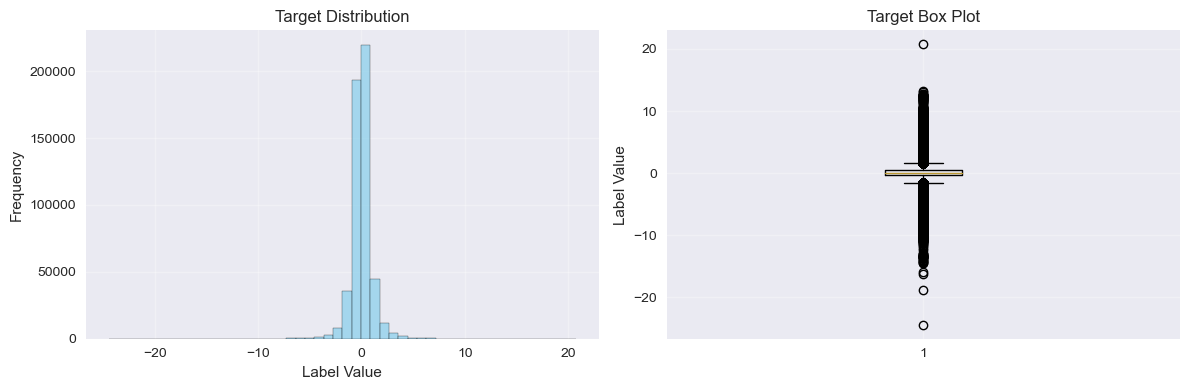


TRAINING BASE MODELS
Training LightGBM (gbdt)...
Training LGBMRegressor

--- Fold 0 - _pearsonr: 0.135342 - Time: 70.12 s
--- Fold 1 - _pearsonr: 0.097771 - Time: 72.33 s
--- Fold 2 - _pearsonr: 0.067621 - Time: 77.83 s
--- Fold 3 - _pearsonr: 0.152706 - Time: 70.81 s
--- Fold 4 - _pearsonr: 0.062459 - Time: 70.59 s

------ Overall _pearsonr: 0.092851 - Mean _pearsonr: 0.103180 ± 0.035886 - Time: 363.32 s
   Fold scores: [0.13534225265777083, 0.09777090485394635, 0.06762132210006491, 0.15270559934937084, 0.06245881271011697]
   Mean CV score: 0.103180
   Std CV score: 0.035886
Training LightGBM (goss)...
Training LGBMRegressor

--- Fold 0 - _pearsonr: 0.174419 - Time: 134.71 s
--- Fold 1 - _pearsonr: 0.104235 - Time: 139.02 s
--- Fold 2 - _pearsonr: 0.028612 - Time: 150.97 s
--- Fold 3 - _pearsonr: 0.117456 - Time: 148.09 s
--- Fold 4 - _pearsonr: 0.078308 - Time: 158.37 s

------ Overall _pearsonr: 0.092698 - Mean _pearsonr: 0.100606 ± 0.047803 - Time: 733.13 s
   Fold scores: [0.174

In [8]:
def main():
    """Main execution function."""
    # Initialize configuration
    config = Config()
    print(f"Configuration initialized!")
    print(f"Training data path: {config.train_path}")
    print(f"Test data path: {config.test_path}")
    print(f"GPU enabled: {config.use_gpu}")
    
    # Create and run predictor
    predictor = CryptoPredictor(config)
    submission_file = predictor.run_pipeline()
    
    print(f"\n🎉 Prediction pipeline completed!")
    print(f"📁 Submission file: {submission_file}")
    print(f"🎯 Pipeline execution completed successfully!")
    print(f"📈 Best model: Ridge Ensemble")

if __name__ == "__main__":
    main()